In [19]:
# --- Setup Kafka + Java + Python dependencies in Google Colab ---

import sys, subprocess, pathlib, os, urllib.request

print("Python:", sys.version)
!java -version || echo "Java not found — installing now"



Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
openjdk version "11.0.28" 2025-07-15
OpenJDK Runtime Environment (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1)
OpenJDK 64-Bit Server VM (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)


In [20]:
# Install Java (if missing), NetworkX for batch metrics, and helpers.
!apt-get -qq update
!apt-get -qq install -y openjdk-11-jdk > /dev/null
!pip -q install kafka-python==2.0.2 networkx==3.2.1 pandas==2.2.2 matplotlib==3.9.0


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [21]:
# --- Define versions ---
KAFKA_VERSION = "3.7.0"
SCALA_VERSION = "2.13"
KAFKA_TGZ = f"kafka_{SCALA_VERSION}-{KAFKA_VERSION}.tgz"
KAFKA_DIR = f"kafka_{SCALA_VERSION}-{KAFKA_VERSION}"

# --- Correct download source (Apache archive) ---
KAFKA_URL = f"https://archive.apache.org/dist/kafka/{KAFKA_VERSION}/{KAFKA_TGZ}"

if not pathlib.Path(KAFKA_DIR).exists():
    print("Downloading Kafka from:", KAFKA_URL)
    !wget -q {KAFKA_URL}
    !tar -xzf {KAFKA_TGZ}
    !rm -f {KAFKA_TGZ}

print("Kafka folder present:", pathlib.Path(KAFKA_DIR).exists())

# --- Set up environment variables ---
os.environ["KAFKA_HOME"] = str(pathlib.Path(KAFKA_DIR).resolve())
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["KAFKA_HOME"], "bin")

!echo "JAVA_HOME:" $JAVA_HOME
!echo "KAFKA_HOME:" $KAFKA_HOME
!ls -1 $KAFKA_HOME/bin | head

Kafka folder present: True
JAVA_HOME: /usr/lib/jvm/java-11-openjdk-amd64
KAFKA_HOME: /content/kafka_2.13-3.7.0
connect-distributed.sh
connect-mirror-maker.sh
connect-plugin-path.sh
connect-standalone.sh
kafka-acls.sh
kafka-broker-api-versions.sh
kafka-client-metrics.sh
kafka-cluster.sh
kafka-configs.sh
kafka-console-consumer.sh


In [22]:
# Start Zookeeper and Kafka broker in the background (daemon mode)
import os, time, subprocess, pathlib

KAFKA_HOME = f"/content/{KAFKA_DIR}"
os.environ["KAFKA_HOME"] = KAFKA_HOME

# Patch server.properties to listen on localhost (good default for Colab)
server_props = f"{KAFKA_HOME}/config/server.properties"
with open(server_props, "r") as f:
    lines = f.read().splitlines()

# Minimal tweak: ensure listeners use PLAINTEXT on localhost:9092 and logs dir is writable
new_lines = []
set_listener = False
set_logsdir = False
for ln in lines:
    if ln.startswith("listeners="):
        new_lines.append("listeners=PLAINTEXT://:9092")
        set_listener = True
    elif ln.startswith("log.dirs="):
        new_lines.append("log.dirs=/content/kafka-logs")
        set_logsdir = True
    else:
        new_lines.append(ln)

if not set_listener:
    new_lines.append("listeners=PLAINTEXT://:9092")
if not set_logsdir:
    new_lines.append("log.dirs=/content/kafka-logs")

with open(server_props, "w") as f:
    f.write("\n".join(new_lines) + "\n")


os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["JAVA_HOME"], "bin")

# Start ZooKeeper and Kafka in background using subprocess
subprocess.Popen([f"{KAFKA_HOME}/bin/zookeeper-server-start.sh", f"{KAFKA_HOME}/config/zookeeper.properties"])
time.sleep(5)
subprocess.Popen([f"{KAFKA_HOME}/bin/kafka-server-start.sh", f"{KAFKA_HOME}/config/server.properties"])
time.sleep(10)

# Verify
!{KAFKA_HOME}/bin/kafka-topics.sh --bootstrap-server localhost:9092 --list || echo "Broker not up yet"

time.sleep(5)
print("Attempting to list topics (should connect):")
!{KAFKA_HOME}/bin/kafka-topics.sh --bootstrap-server localhost:9092 --list || echo "Broker not up yet"


__consumer_offsets
wiki-vote
Attempting to list topics (should connect):
__consumer_offsets
wiki-vote


In [23]:
TOPIC = "wiki-vote"

# Create the topic if it doesn't exist
code = os.system(f"{KAFKA_HOME}/bin/kafka-topics.sh --bootstrap-server localhost:9092 --create --if-not-exists --topic {TOPIC} --partitions 1 --replication-factor 1")
print("Topic create exit code:", code)
print("Current topics:")
!{KAFKA_HOME}/bin/kafka-topics.sh --bootstrap-server localhost:9092 --list


Topic create exit code: 0
Current topics:
__consumer_offsets
wiki-vote


In [24]:
# Download and extract the dataset (edges as source target per line; "Wiki-Vote.txt.gz")
import pathlib
if not pathlib.Path("Wiki-Vote.txt").exists():
    !wget -q https://snap.stanford.edu/data/Wiki-Vote.txt.gz
    !gunzip -f Wiki-Vote.txt.gz

    # Fix possible case; normalize filename to "Wiki-Vote.txt"
    if pathlib.Path("wiki-Vote.txt").exists():
        !mv wiki-Vote.txt Wiki-Vote.txt

# Quick peek
!head -n 10 Wiki-Vote.txt


# Directed graph (each unordered pair of nodes is saved once): Wiki-Vote.txt 
# Wikipedia voting on promotion to administratorship (till January 2008). Directed edge A->B means user A voted on B becoming Wikipedia administrator.
# Nodes: 7115 Edges: 103689
# FromNodeId	ToNodeId
30	1412
30	3352
30	5254
30	5543
30	7478
3	28


In [25]:
import networkx as nx

# Build directed graph from file, skipping comments
G = nx.DiGraph()
with open("Wiki-Vote.txt", "r") as f:
    for line in f:
        if not line.strip() or line.startswith("#"):
            continue
        s, t = line.strip().split()
        G.add_edge(int(s), int(t))

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Weakly/Strongly connected components (sizes)
wcc_sizes = [len(c) for c in nx.weakly_connected_components(G)]
scc_sizes = [len(c) for c in nx.strongly_connected_components(G)]
largest_wcc = max(wcc_sizes) if wcc_sizes else 0
largest_scc = max(scc_sizes) if scc_sizes else 0

# Directed triangles are non-trivial. For comparison we compute *undirected* triangles
# to avoid very heavy directed-triangle enumeration in a teaching notebook.
# We'll still report basic clustering using the undirected projection.
UG = G.to_undirected()
avg_clustering = nx.average_clustering(UG)

print("=== Batch metrics (computed now) ===")
print(f"Nodes: {num_nodes}")
print(f"Edges: {num_edges}")
print(f"Largest WCC size: {largest_wcc} (frac={largest_wcc/num_nodes:.3f})")
print(f"Largest SCC size: {largest_scc} (frac={largest_scc/num_nodes:.3f})")
print(f"Average clustering coefficient (undirected): {avg_clustering:.4f}")

print("\n=== Provided ground truth (from assignment prompt) ===")
print("Nodes=7115, Edges=103689")
print("Largest WCC=7066 (0.993), Largest SCC=1300 (0.183)")
print("Average clustering coefficient≈0.1409")
print("Triangles=608389, Fraction closed=0.04564")
print("Diameter=7, 90% effective diameter=3.8")


=== Batch metrics (computed now) ===
Nodes: 7115
Edges: 103689
Largest WCC size: 7066 (frac=0.993)
Largest SCC size: 1300 (frac=0.183)
Average clustering coefficient (undirected): 0.1409

=== Provided ground truth (from assignment prompt) ===
Nodes=7115, Edges=103689
Largest WCC=7066 (0.993), Largest SCC=1300 (0.183)
Average clustering coefficient≈0.1409
Triangles=608389, Fraction closed=0.04564
Diameter=7, 90% effective diameter=3.8


In [26]:
# --- UPDATED: Streaming consumer + analytics to meet assignment tasks ---

from confluent_kafka import Consumer, KafkaException
from collections import deque, defaultdict
import time, json, math
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

GROUND_TRUTH_NODES = 7115
GROUND_TRUTH_EDGES = 103689
TOPIC = "wiki-vote"
GROUP_ID = "wiki-consumer-1"
BOOTSTRAP_SERVERS = "localhost:9092"

class StreamingGraphAnalytics:
    """
    Maintains:
      - Running node/edge counts
      - Sliding-window edges/sec (EPS)
      - Largest WCC/SCC periodically
      - Average clustering (undirected projection) periodically
      - Approximate out-degree distribution in log2 buckets (state-light)
    """
    def __init__(self, window_sec=10, update_interval=5_000):
        self.G = nx.DiGraph()
        self.edges = 0
        self.events = deque()  # timestamps for EPS window
        self.window_sec = window_sec
        self.update_interval = update_interval
        self.last_update = 0
        self.last_log = 0
        self.history = []  # rows appended as dicts (timestamped metrics)
        # approximate degree histogram: bucket k for degrees in [2^k, 2^(k+1)-1]
        self.deg_bucket = defaultdict(int)
        self._degrees = defaultdict(int)  # track current out-deg to update buckets minimally

    def _bucket_of(self, d):
        if d <= 0: return -1  # ignore
        return int(math.log2(d))

    def _inc_outdeg(self, u):
        old = self._degrees[u]
        new = old + 1
        self._degrees[u] = new
        if old > 0:
            self.deg_bucket[self._bucket_of(old)] -= 1
        self.deg_bucket[self._bucket_of(new)] += 1

    def update(self, src, tgt):
        now = time.time()
        # add edge if new (protect ordering/duplicates)
        if not self.G.has_edge(src, tgt):
            self.G.add_edge(src, tgt)
            self.edges += 1
            self._inc_outdeg(src)

        # window for EPS
        self.events.append(now)
        cutoff = now - self.window_sec
        while self.events and self.events[0] < cutoff:
            self.events.popleft()
        eps = len(self.events) / self.window_sec

        # Periodic heavy metrics
        if self.edges - self.last_update >= self.update_interval:
            self.last_update = self.edges

            # sizes of components
            try:
                wcc_sizes = [len(c) for c in nx.weakly_connected_components(self.G)]
                scc_sizes = [len(c) for c in nx.strongly_connected_components(self.G)]
                largest_wcc = max(wcc_sizes) if wcc_sizes else 0
                largest_scc = max(scc_sizes) if scc_sizes else 0
            except Exception:
                largest_wcc = largest_scc = 0

            # clustering on undirected projection (approx; can be slow when very large)
            try:
                avg_clustering = nx.average_clustering(self.G.to_undirected())
            except Exception:
                avg_clustering = float("nan")

            # snapshot degree buckets
            buckets_snapshot = dict(self.deg_bucket)

            self.history.append({
                "t": now,
                "nodes": self.G.number_of_nodes(),
                "edges": self.edges,
                "eps": eps,
                "largest_wcc": largest_wcc,
                "largest_scc": largest_scc,
                "avg_clustering": avg_clustering,
                "deg_buckets": buckets_snapshot,
            })

            if now - self.last_log > 5:
                self.last_log = now
                print(f"[metrics] nodes={self.G.number_of_nodes()} edges={self.edges} "
                      f"WCC={largest_wcc} SCC={largest_scc} cluster={avg_clustering:.4f} eps={eps:.1f}")

        return eps

    def reached_truth(self):
        return (self.G.number_of_nodes() >= GROUND_TRUTH_NODES and
                self.edges >= GROUND_TRUTH_EDGES)

def run_consumer_with_graph(
    stop_after_reach=True,
    window_sec=10,
    poll_timeout=0.2,
    group_id=GROUP_ID,
    bootstrap=BOOTSTRAP_SERVERS,
):
    """
    Fault tolerance: stable group.id with auto-commit so restarts resume offsets.
    """
    conf = {
        "bootstrap.servers": bootstrap,
        "group.id": group_id,
        "auto.offset.reset": "earliest",
        "enable.auto.commit": True,
    }
    consumer = Consumer(conf)
    consumer.subscribe([TOPIC])

    analyzer = StreamingGraphAnalytics(window_sec=window_sec)
    t0 = time.time()
    reached_once = False

    try:
        idle_ms = 0
        while True:
            msg = consumer.poll(poll_timeout)
            if msg is None:
                idle_ms += int(poll_timeout * 1000)
                if idle_ms >= 30000:
                  print("[consumer] Waiting for producer… (no messages yet)")
                  idle_ms = 0

                continue
            idle_ms = 0

            if msg.error():
                raise KafkaException(msg.error())

            try:
                payload = json.loads(msg.value().decode("utf-8"))
                # accept either str or int ids
                src = int(payload["src"])
                tgt = int(payload["dst"])
            except Exception:
                continue

            analyzer.update(src, tgt)

            if not reached_once and analyzer.reached_truth():
                reached_once = True
                print(f"[done] Reached ground truth at t={time.time()-t0:.1f}s "
                      f"({analyzer.G.number_of_nodes()} nodes, {analyzer.edges} edges)")
                if stop_after_reach:
                    break

        # Prepare a tidy DataFrame of periodic metrics for plotting/report
        df = pd.DataFrame(analyzer.history)
        if not df.empty:
            df["t_rel_sec"] = df["t"] - df["t"].iloc[0]
        return analyzer, df

    finally:
        consumer.close()


In [27]:
!pip uninstall -y kafka-python > /dev/null
!pip install -q confluent-kafka pandas networkx matplotlib

from confluent_kafka import Producer
import random, time, json

BOOTSTRAP_SERVERS = "localhost:9092"
TOPIC = "wiki-vote"

def load_edges(path="Wiki-Vote.txt", shuffle=True):
    edges = []
    with open(path, "r") as f:
        for line in f:
            if not line.strip() or line.startswith("#"):
                continue
            s, t = line.strip().split()
            edges.append((int(s), int(t)))
    if shuffle:
        random.shuffle(edges)  # Ordering experiment
    return edges

def run_producer(
    delay_sec=0.001,
    shuffle=True,
    queue_soft_limit=150_000,
    bootstrap=BOOTSTRAP_SERVERS,
    topic=TOPIC,
):
    """
    Latency: control with delay_sec
    Ordering: control with shuffle
    Throughput/backpressure: queue_soft_limit & poll
    """
    conf = {
        "bootstrap.servers": bootstrap,
        "linger.ms": 5,
        "queue.buffering.max.kbytes": 256000,
        "queue.buffering.max.messages": 500000,
    }
    producer = Producer(conf)
    edges = load_edges(shuffle=shuffle)
    print(f"Streaming {len(edges)} edges to topic '{topic}' | delay={delay_sec}s | shuffle={shuffle}")

    sent = 0
    start = time.time()

    def dr_cb(err, _msg):
        if err is not None:
            print("[produce-delivery-error]", err)

    for s, t in edges:
        msg = json.dumps({"src": s, "dst": t}).encode("utf-8")

        # soft backpressure to avoid BufferError storms
        while len(producer) > queue_soft_limit:
            producer.poll(0.1)

        while True:
            try:
                producer.produce(topic, value=msg, on_delivery=dr_cb)
                break
            except BufferError:
                producer.poll(0.1)

        sent += 1
        producer.poll(0)
        if delay_sec > 0:
            time.sleep(delay_sec)

        if sent % 10000 == 0:
            print(f"  sent {sent} messages… (queued={len(producer)})")

    producer.flush()
    elapsed = time.time() - start
    print(f" Done. Sent {sent} messages in {elapsed:.2f}s (avg {sent/elapsed:.1f} msg/s).")

Streaming 103689 edges to topic 'wiki-vote' | delay=0.001s | shuffle=True
  sent 10000 messages… (queued=2)
  sent 20000 messages… (queued=7)
  sent 30000 messages… (queued=4)
  sent 40000 messages… (queued=7)
  sent 50000 messages… (queued=7)
  sent 60000 messages… (queued=4)
  sent 70000 messages… (queued=4)
  sent 80000 messages… (queued=4)
  sent 90000 messages… (queued=2)
  sent 100000 messages… (queued=2)
 Done. Sent 103689 messages in 122.31s (avg 847.7 msg/s).
[metrics] nodes=2742 edges=5000 WCC=2604 SCC=315 cluster=0.0065 eps=500.0
[metrics] nodes=5675 edges=50000 WCC=5643 SCC=1148 cluster=0.0734 eps=5000.0
[metrics] nodes=6159 edges=65000 WCC=6123 SCC=1209 cluster=0.0930 eps=3000.0
[metrics] nodes=6437 edges=75000 WCC=6394 SCC=1240 cluster=0.1072 eps=2000.0
[metrics] nodes=6697 edges=85000 WCC=6651 SCC=1257 cluster=0.1204 eps=1500.0
[metrics] nodes=6939 edges=95000 WCC=6891 SCC=1285 cluster=0.1326 eps=1500.0
[metrics] nodes=7048 edges=100000 WCC=6999 SCC=1294 cluster=0.1367 e

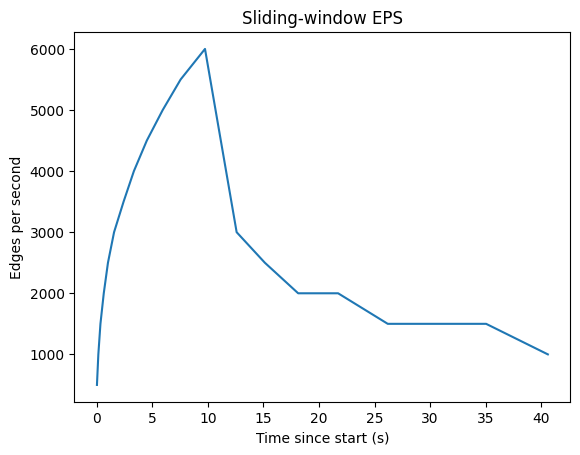

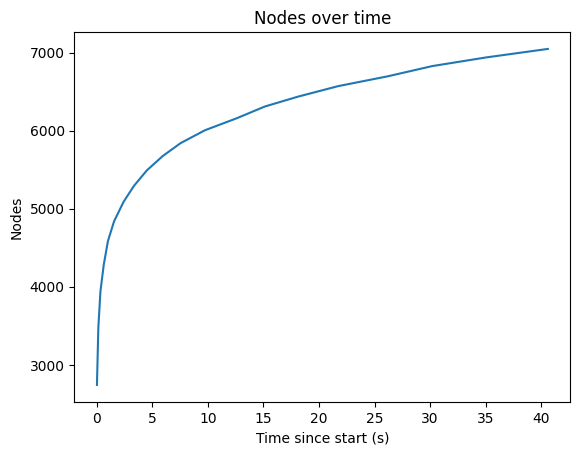

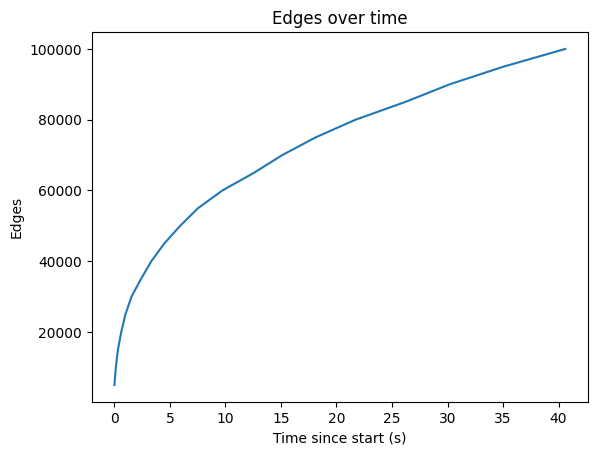

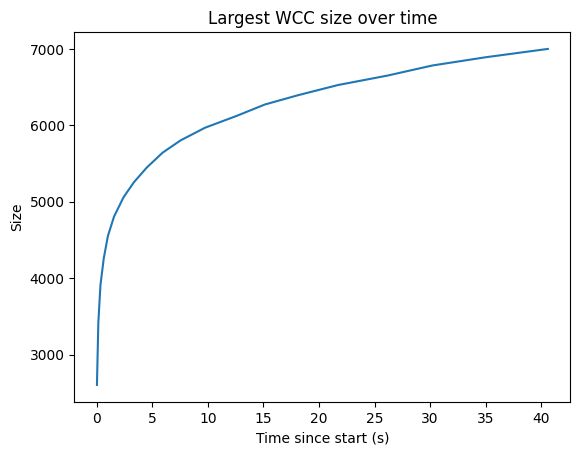

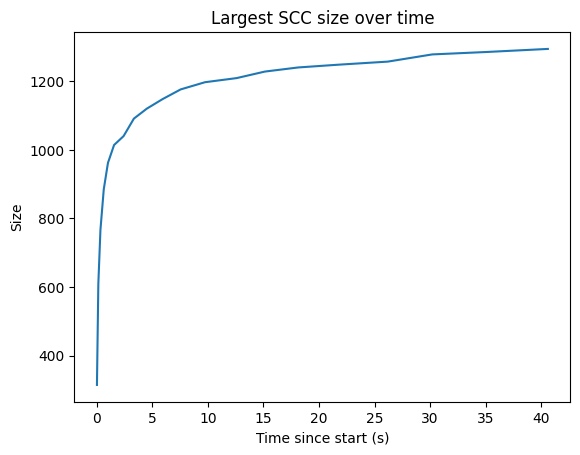

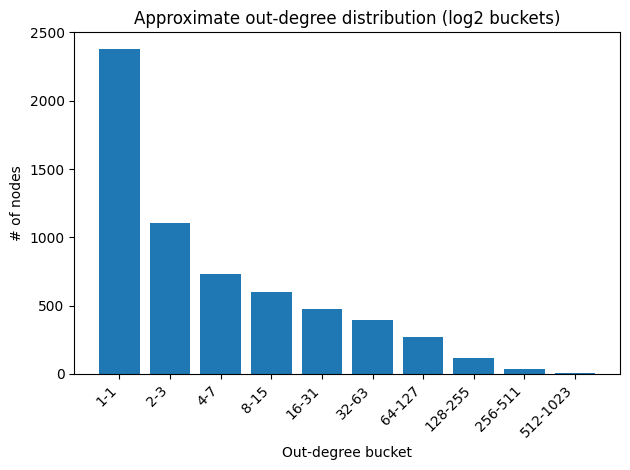

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_stream_metrics(df: pd.DataFrame):
    if df.empty:
        print("No periodic metrics captured (increase update_interval or run longer).")
        return
    # EPS over time
    plt.figure()
    plt.plot(df["t_rel_sec"], df["eps"])
    plt.xlabel("Time since start (s)")
    plt.ylabel("Edges per second")
    plt.title("Sliding-window EPS")
    plt.show()

    # Nodes/Edges over time
    plt.figure()
    plt.plot(df["t_rel_sec"], df["nodes"])
    plt.xlabel("Time since start (s)")
    plt.ylabel("Nodes")
    plt.title("Nodes over time")
    plt.show()

    plt.figure()
    plt.plot(df["t_rel_sec"], df["edges"])
    plt.xlabel("Time since start (s)")
    plt.ylabel("Edges")
    plt.title("Edges over time")
    plt.show()

    # Largest components
    plt.figure()
    plt.plot(df["t_rel_sec"], df["largest_wcc"])
    plt.xlabel("Time since start (s)")
    plt.ylabel("Size")
    plt.title("Largest WCC size over time")
    plt.show()

    plt.figure()
    plt.plot(df["t_rel_sec"], df["largest_scc"])
    plt.xlabel("Time since start (s)")
    plt.ylabel("Size")
    plt.title("Largest SCC size over time")
    plt.show()


def latest_degree_histogram(analyzer):
    if not hasattr(analyzer, "deg_bucket") or not analyzer.deg_bucket:
        print("No degree data yet.")
        return
    items = sorted((k, v) for k, v in analyzer.deg_bucket.items() if v > 0)
    labels, counts = [], []
    for k, v in items:
        lo = 1 if k == 0 else 2**k
        hi = 2**(k+1) - 1
        labels.append(f"{lo}-{hi}")
        counts.append(v)

    plt.figure()
    plt.bar(range(len(counts)), counts)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.xlabel("Out-degree bucket")
    plt.ylabel("# of nodes")
    plt.title("Approximate out-degree distribution (log2 buckets)")
    plt.tight_layout()
    plt.show()

run_producer(delay_sec=0.001, shuffle=True)
analyzer, df = run_consumer_with_graph(stop_after_reach=True)
plot_stream_metrics(df)
latest_degree_histogram(analyzer)